In [35]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from binance.client import Client
from binance import ThreadedWebsocketManager
from sklearn.preprocessing import LabelEncoder
from os import getenv
import warnings
warnings.filterwarnings('ignore')

In [2]:
api_key = getenv('api_key')
secret_key = getenv('api_secret')

In [4]:
# Encode the target labels
le_trend = LabelEncoder()
le_action = LabelEncoder()
le_amount = LabelEncoder()

In [5]:
client = Client(api_key = api_key, api_secret= secret_key, tld= 'com')

In [6]:
client

In [7]:
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_5MINUTE
start_date = '2023-01-01'
end_date = '2024-11-02'

In [8]:
data = client.get_historical_klines(symbol, interval, start_str=start_date,end_str=end_date)

In [9]:
df = pd.DataFrame(data, columns=[
    'timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
    'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume', 'ignore'
])

In [10]:
#Data Manipulation
# Convert the 'timestamp' column to a readable date format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Select relevant columns
df = df[['open', 'high', 'low', 'close', 'volume']]

# Convert data types to numeric for analysis
df = df.apply(pd.to_numeric)

In [11]:
dataset = df

In [12]:
# Assuming 'data' is your DataFrame with 'close' and 'volume' columns
dataset['RSI'] = ta.rsi(dataset['close'], length=14)
# Adding the MA calculations
dataset['EMA_5'] = dataset['close'].ewm(span=5, adjust=False).mean()
dataset['EMA_30'] = dataset['close'].ewm(span=30, adjust=False).mean()
dataset['EMA_90'] = dataset['close'].ewm(span=90, adjust=False).mean()
#Volume 
dataset['volume_sma_3'] = dataset['volume'].rolling(window=3).mean()  # 3-day SMA for volume
# Calculate Bollinger Bands
bbands = ta.bbands(dataset['close'], length=20, std=2)

In [13]:
#Adding the limits of the Bollinger Bands
dataset['BB_upper'] = bbands['BBU_20_2.0']
dataset['BB_middle'] = bbands['BBM_20_2.0']
dataset['BB_lower'] = bbands['BBL_20_2.0']

In [14]:
# Step 2: Determine trend based on EMA alignment
def determine_trend(row):
    if (row['EMA_5'] > row['EMA_30'] > row['EMA_90']) & (row['close'] > row['BB_middle']) & (row['RSI'] < 70) & (row['volume'] > row['volume_sma_3']):
        return 'strong_upward'
    elif (row['EMA_5'] < row['EMA_30'] < row['EMA_90']) & (row['close'] < row['BB_middle']) & (row['RSI'] > 30):
        return 'strong_downward'
    elif (row['EMA_5'] > row['EMA_30'] < row['EMA_90']) & (row['RSI'] > 30) & (row['close'] < row['BB_middle']) & (row['volume'] < row['volume_sma_3']):
        return 'downward'
    elif (row['EMA_5'] < row['EMA_30'] > row['EMA_90']) & (row['RSI'] < 70) & (row['close'] > row['BB_lower']) & (row['volume'] > row['volume_sma_3']):
        return 'upward'
    else:
        return 'sideways'

In [15]:
dataset['trend'] = dataset.apply(determine_trend, axis=1)

In [16]:
# Step 3: Define actions and amounts based on the trend
def determine_action_amount(trend):
    if trend == 'strong_upward':
        return 'buy', 'all'
    elif trend == 'upward':
        return 'buy', 'half'
    elif trend == 'sideways':
        return 'hold', 'half'
    elif trend == 'downward':
        return 'sell', 'half'
    elif trend == 'strong_downward':
        return 'sell', 'all'
    else:
        return 'hold', 'none'

In [17]:
dataset[['action', 'amount']] = dataset['trend'].apply(lambda x: pd.Series(determine_action_amount(x)))

In [18]:
# Target columns (shifted to predict the next action)
dataset['target_trend'] = dataset['trend'].shift(-1)
dataset['target_action'] = dataset['action'].shift(-1)
dataset['target_amount'] = dataset['amount'].shift(-1)

In [19]:
dataset

,open,high,low,close,volume,RSI,EMA_5,EMA_30,EMA_90,volume_sma_3,BB_upper,BB_middle,BB_lower,trend,action,amount,target_trend,target_action,target_amount
timestamp,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,NaN,16535.380000,16535.380000,16535.380000,NaN,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,NaN,16532.476667,16534.818065,16535.188571,NaN,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,NaN,16528.547778,16533.906576,16534.869922,390.846117,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,NaN,16530.678519,16533.973249,16534.871462,389.039030,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,NaN,16532.299012,16534.074330,16534.886155,361.819517,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01 23:40:00,69485.12,69515.16,69479.90,69489.83,27.34582,57.351248,69499.354209,69397.646767,69503.901125,20.330643,69614.752757,69435.4080,69256.063243,sideways,hold,half,sideways,hold,half
2024-11-01 23:45:00,69489.83,69499.99,69472.00,69484.00,36.44869,56.777375,69494.236140,69403.217944,69503.463738,26.405213,69619.073497,69441.0075,69262.941503,sideways,hold,half,sideways,hold,half
2024-11-01 23:50:00,69484.01,69560.00,69478.00,69540.00,33.85343,60.831645,69509.490760,69412.042592,69504.266732,32.549313,69630.007115,69447.5075,69265.007885,sideways,hold,half,sideways,hold,half


In [20]:
# Drop rows with NaN values in the target
df2 = dataset.dropna().copy()

In [22]:
# Fit and transform the labels
df2['target_trend'] = le_trend.fit_transform(df2['target_trend'])
df2['target_action'] = le_action.fit_transform(df2['target_action'])
df2['target_amount'] = le_amount.fit_transform(df2['target_amount'])

In [28]:
# Define features 
X = df2[['EMA_5', 'EMA_30', 'EMA_90', 'volume', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower', 'volume_sma_3']]

In [29]:
# Define targets
y_trend = df2['target_trend']
y_action = df2['target_action']
y_amount = df2['target_amount']

In [30]:
# Split the data
X_train_trend, X_test_trend, y_train_trend, y_test_trend = train_test_split(X, y_trend, test_size=0.2, random_state=101)
X_train_action, X_test_action, y_train_action, y_test_action = train_test_split(X, y_action, test_size=0.2, random_state=101)
X_train_amount, X_test_amount, y_train_amount, y_test_amount = train_test_split(X, y_amount, test_size=0.2, random_state=101)

In [31]:
# Without Optimization
#Trend Model
model = RandomForestClassifier(random_state=101)
model.fit(X_train_trend, y_train_trend)
y_pred_trend = model.predict(X_test_trend)
print("accuracy: "+ str(accuracy_score(y_test_trend, y_pred_trend)))
print("precision: "+ str(precision_score(y_test_trend, y_pred_trend, average="weighted")))
print("recall: " + str(recall_score(y_test_trend, y_pred_trend, average="weighted")))
print( "f1_score: " + str(f1_score(y_test_trend, y_pred_trend, average="weighted")))
print(confusion_matrix(y_test_trend, y_pred_trend))

accuracy: 0.7097533835364749
precision: 0.6607091012925433
recall: 0.7097533835364749
f1_score: 0.6636065923348938
[[    0   289    22     1     1]
 [    4 20498  2144   434   277]
 [    0  2219  6456     0    41]
 [    0  3790    11   324     6]
 [    0  1637   334     6   149]]


In [32]:
#Action Model
model_action = RandomForestClassifier(random_state=101)
model_action.fit(X_train_action, y_train_action)
y_pred_action = model_action.predict(X_test_action)
print("accuracy: "+ str(accuracy_score(y_test_action, y_pred_action)))
print("precision: "+ str(precision_score(y_test_action, y_pred_action, average="weighted")))
print("recall: " + str(recall_score(y_test_action, y_pred_action, average="weighted")))
print( "f1_score: " + str(f1_score(y_test_action, y_pred_action, average="weighted")))
print(confusion_matrix(y_test_action, y_pred_action))

accuracy: 0.7077090288021116
precision: 0.6647739220893525
recall: 0.7077090288021116
f1_score: 0.6669716129909431
[[  533  5350   374]
 [  831 20314  2212]
 [   40  2488  6501]]


In [33]:
#Amount Model
model_amount = RandomForestClassifier(random_state=101)
model_amount.fit(X_train_amount, y_train_amount)
y_pred_amount = model_amount.predict(X_test_amount)
print("accuracy: "+ str(accuracy_score(y_test_amount, y_pred_amount)))
print("precision: "+ str(precision_score(y_test_amount, y_pred_amount, average="weighted")))
print("recall: " + str(recall_score(y_test_amount, y_pred_amount, average="weighted")))
print( "f1_score: " + str(f1_score(y_test_amount, y_pred_amount, average="weighted")))
print(confusion_matrix(y_test_amount, y_pred_amount))

accuracy: 0.7822374039282665
precision: 0.7780943124601262
recall: 0.7822374039282665
f1_score: 0.769826170067731
[[ 6619  6228]
 [ 2187 23609]]


In [39]:
# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [40]:
# Grid search for each target model
def optimize_model(X_train, y_train):
    model = RandomForestClassifier(random_state=101)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters found: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [41]:
# Optimize Trend Model
print("Optimizing trend model...")
model_trend = optimize_model(X_train_trend, y_train_trend)

Optimizing trend model...
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [42]:
# Optimize Action Model
print("Optimizing action model...")
model_action = optimize_model(X_train_action, y_train_action)

Optimizing action model...
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [43]:
# Optimize Amount Model
print("Optimizing amount model...")
model_amount = optimize_model(X_train_amount, y_train_amount)

Optimizing amount model...
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [44]:
#Trend Model
y_pred_optimized_trend = model_trend.predict(X_test_trend)
print("accuracy: "+ str(accuracy_score(y_test_trend, y_pred_optimized_trend)))
print("precision: "+ str(precision_score(y_test_trend, y_pred_optimized_trend, average="weighted")))
print("recall: " + str(recall_score(y_test_trend, y_pred_optimized_trend, average="weighted")))
print( "f1_score: " + str(f1_score(y_test_trend, y_pred_optimized_trend, average="weighted")))
print(confusion_matrix(y_test_trend, y_pred_optimized_trend))

accuracy: 0.7007219936340346
precision: 0.6501403558295222
recall: 0.7007219936340346
f1_score: 0.6405872756708703
[[    0   298    15     0     0]
 [    0 20484  2711    69    93]
 [    0  2226  6478     0    12]
 [    0  4066     8    55     2]
 [    0  1430   635     0    61]]


In [45]:
#Action Model
y_pred_optimized_action = model_action.predict(X_test_action)
print("accuracy: "+ str(accuracy_score(y_test_action, y_pred_optimized_action)))
print("precision: "+ str(precision_score(y_test_action, y_pred_optimized_action, average="weighted")))
print("recall: " + str(recall_score(y_test_action, y_pred_optimized_action, average="weighted")))
print( "f1_score: " + str(f1_score(y_test_action, y_pred_optimized_action, average="weighted")))
print(confusion_matrix(y_test_action, y_pred_optimized_action))

accuracy: 0.7014983308749321
precision: 0.6498568374901629
recall: 0.7014983308749321
f1_score: 0.6447786016955032
[[  121  5493   643]
 [  188 20454  2715]
 [   14  2482  6533]]


In [46]:
#Amount Model
y_pred_optimized_amount = model_amount.predict(X_test_amount)
print("accuracy: "+ str(accuracy_score(y_test_amount, y_pred_optimized_amount)))
print("precision: "+ str(precision_score(y_test_amount, y_pred_optimized_amount, average="weighted")))
print("recall: " + str(recall_score(y_test_amount, y_pred_optimized_amount, average="weighted")))
print( "f1_score: " + str(f1_score(y_test_amount, y_pred_optimized_amount, average="weighted")))
print(confusion_matrix(y_test_amount, y_pred_optimized_amount))

accuracy: 0.7666847812022876
precision: 0.761417042981226
recall: 0.7666847812022876
f1_score: 0.7508817602630967
[[ 6048  6799]
 [ 2217 23579]]


In [47]:
# Retrieve the mappings
trend_mapping = {index: label for index, label in enumerate(le_trend.classes_)}
action_mapping = {index: label for index, label in enumerate(le_action.classes_)}
amount_mapping = {index: label for index, label in enumerate(le_amount.classes_)}

print("Trend Mapping:", trend_mapping)
print("Action Mapping:", action_mapping)
print("Amount Mapping:", amount_mapping)

Trend Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Action Mapping: {0: 0, 1: 1, 2: 2}
Amount Mapping: {0: 0, 1: 1}


In [48]:
# Count combinations
df2['strategy'] = df2['target_trend'].astype(str) + "-" + df2['target_action'].astype(str) + "-" + df2['target_amount'].astype(str)
strategy_counts = df2['strategy'].value_counts().sort_index()

# Map numbers back to labels for clarity in combinations
def decode_strategy(strategy, trend_mapping, action_mapping, amount_mapping):
    trend, action, amount = map(int, strategy.split("-"))
    return f"{trend_mapping[trend]}-{action_mapping[action]}-{amount_mapping[amount]}"

decoded_strategies = {decode_strategy(key, trend_mapping, action_mapping, amount_mapping): value for key, value in strategy_counts.items()}

print(decoded_strategies)

{'0-2-1': 1567, '1-1-1': 116964, '2-2-0': 43384, '3-0-0': 20401, '4-0-1': 10897}


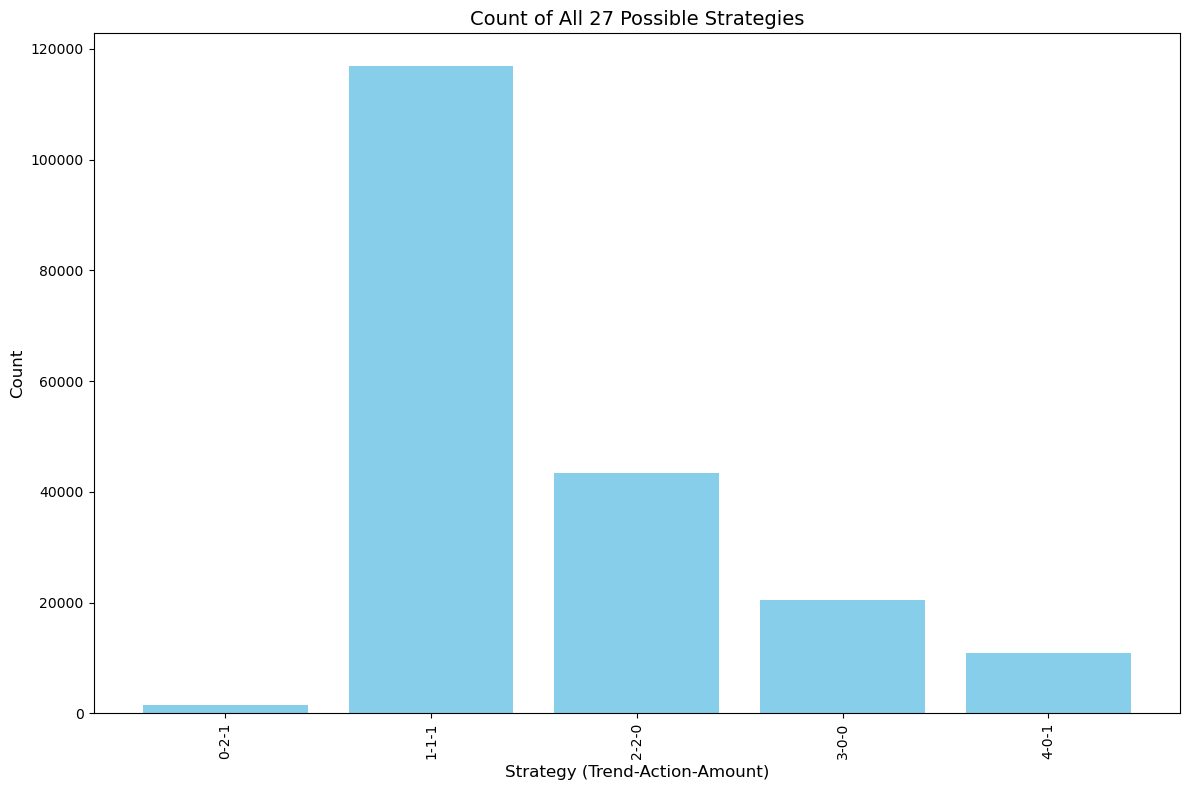

In [49]:
# Decode strategy names for the plot
strategy_names = [decode_strategy(key, trend_mapping, action_mapping, amount_mapping) for key in strategy_counts.index]
counts = strategy_counts.values

# Plot
plt.figure(figsize=(12, 8))
plt.bar(strategy_names, counts, color='skyblue')
plt.xlabel('Strategy (Trend-Action-Amount)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of All 27 Possible Strategies', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [50]:
dataset

,open,high,low,close,volume,RSI,EMA_5,EMA_30,EMA_90,volume_sma_3,BB_upper,BB_middle,BB_lower,trend,action,amount,target_trend,target_action,target_amount
timestamp,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,NaN,16535.380000,16535.380000,16535.380000,NaN,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,NaN,16532.476667,16534.818065,16535.188571,NaN,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,NaN,16528.547778,16533.906576,16534.869922,390.846117,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,NaN,16530.678519,16533.973249,16534.871462,389.039030,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,NaN,16532.299012,16534.074330,16534.886155,361.819517,NaN,NaN,NaN,sideways,hold,half,sideways,hold,half
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01 23:40:00,69485.12,69515.16,69479.90,69489.83,27.34582,57.351248,69499.354209,69397.646767,69503.901125,20.330643,69614.752757,69435.4080,69256.063243,sideways,hold,half,sideways,hold,half
2024-11-01 23:45:00,69489.83,69499.99,69472.00,69484.00,36.44869,56.777375,69494.236140,69403.217944,69503.463738,26.405213,69619.073497,69441.0075,69262.941503,sideways,hold,half,sideways,hold,half
2024-11-01 23:50:00,69484.01,69560.00,69478.00,69540.00,33.85343,60.831645,69509.490760,69412.042592,69504.266732,32.549313,69630.007115,69447.5075,69265.007885,sideways,hold,half,sideways,hold,half


In [51]:
# Concatenate the three columns into a single column
dataset['final_strategy'] = dataset['target_trend'] + '-' + dataset['target_action'] + '-' + dataset['target_amount']

# Count the occurrences of each unique concatenation
strategy_counts = dataset['final_strategy'].value_counts().reset_index()
strategy_counts.columns = ['final_strategy', 'count']

# Display the result
print("Concatenated strategies and their counts:")
print(strategy_counts)

Concatenated strategies and their counts:
             final_strategy   count
0        sideways-hold-half  116983
1  strong_downward-sell-all   43384
2     strong_upward-buy-all   20401
3           upward-buy-half   10897
4        downward-sell-half    1567
